In [1]:
import numpy as np
import scipy as sp
from scipy.ndimage import filters
import matplotlib.pyplot as plt
from PIL import Image
import time

In [2]:
# load and image for working
im_path = 'D:\\dog_cat_images\\test\\'

pil_im = Image.open(im_path+'1.jpg').convert('L')
im = np.array(pil_im)

## Chapter 2 - Local Image Descriptors
### Harris Corner Detector

1. Basic usage

In [3]:
def compute_harris_response(im, sigma = 3):
    '''Compute the Harris corener detector response function for each pixel in a greyscale image.
    
    im: np.array
        greyscaled image as an array
    sigma: float 
        gaussian filter scale
    
    Return: float
        Harris indicator ratio
    '''
    
    # get gradients
    imx = np.zeros(im.shape)
    imy = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0,1), imx)
    filters.gaussian_filter(im, (sigma, sigma), (1,0), imy)
    
    # computer components of the Harris Matrix
    Wxx = filters.gaussian_filter(imx*imx, sigma)
    Wxy = filters.gaussian_filter(imx*imy, sigma)
    Wyy = filters.gaussian_filter(imy*imy, sigma)
    
    # calc determinate and trace
    Wdet = Wxx*Wyy-Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

In [4]:
def get_harris_points(harris_im, min_dist = 10, threshold = 0.1):
    '''Returns corner from a Harris response image.
    
    harris_im: np.array
        image of harris responses
    min_dist: int
        minimum number of pixels separating the corners and the image boundry
    threshold: 
        response threshold
    
    Return: np.array
        corrds of interesting points
    '''
    
    # find best candidate pixels
    corner_threshold = harris_im.max() * threshold
    harris_im_t = (harris_im > corner_threshold) * 1
    
    # get coordinate of the candidates
    corrds = np.array(harris_im_t.nonzero()).T
    
    # get candidate values
    candidate_values = [harris_im[c[0],c[1]] for c in corrds]
    index = np.argsort(candidate_values)
    
    # filter based on min dist in the image boundry
    allowed_locations = np.zeros(harris_im.shape)
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1
    
    # select the best points accounting for min_dist between pixels
    filtered_corrds = list()
    for i in index:
        if allowed_locations[corrds[i,0],corrds[i,1]] == 1:
            filtered_corrds.append(corrds[i])
            allowed_locations[(corrds[i,0]-min_dist):(corrds[i,1])+min_dist,
                             (corrds[i,1]-min_dist):(corrds[i,1])+min_dist] = 0
    
    return filtered_corrds

In [5]:
def plot_harris_points(image, filtered_corrds, figsize = (10,7)):
    '''Plots the image with the detected corner points.
    
    image: PIL object
        the image used to fit the harris detector
    filter_corrds: np.array
        the harris detector points
    figsize: tuple
        the figure size for plotting
    
    returns: None
        Output is plotted
    '''
    plt.figure(figsize = figsize)
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    plt.plot([p[1] for p in filtered_corrds], [p[0] for p in filtered_corrds], '*')

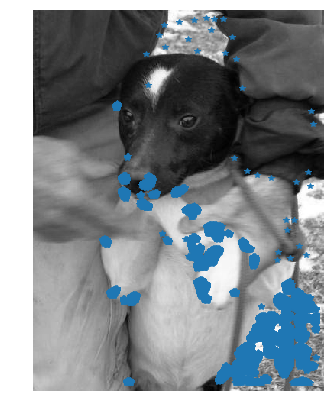

In [6]:
harris_im = compute_harris_response(im)
filtered_corrds = get_harris_points(harris_im, threshold = 0.05)
plot_harris_points(im, filtered_corrds)

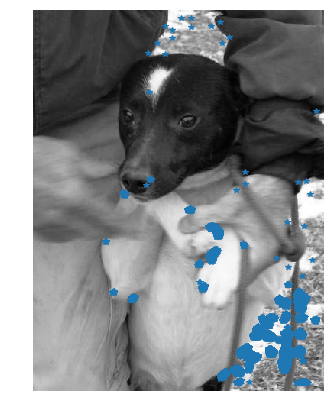

In [7]:
from harris import Harris
new_har = Harris()
new_har.fit(im)
new_har.plot()

2. Finding Corresponding Points Between Images

    - **Interest Point Descripter** - a vector assigned to each point of interest that describes the image apparence around the point.
    - **Corresponding Points** - points in deiiferent images that refer to the same scene or object.
    - **Image Patch** - a rectangular area of the image centered around the point of interest.
    
Define a patch around the points of interest and generate a descriptor from those matches.

In [9]:
def get_image_descriptors(image, filtered_corrds, width = 5):
    '''For each point in the returned corrds, generate patchs around the points.
    '''
    
    desc = list()
    for corrd in filtered_corrds:
        patch = image[corrd[0] - width:corrd[0] + width + 1,
                     corrd[1] - width:corrd[1] + width + 1].flatten()
        desc.append(patch)
    return desc

In [30]:
def match_descriptors(desc1, desc2, threshold = 0.5):
    '''Match the first descriptor to the second descriptor using normalized corss-correlation.
    '''
    
    n = len(desc1[0])
    
    d = -np.ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i])
        for j in range(len(desc2)):
            d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j])
            ncc_val = np.sum(d1 * d2) / (n-1)
            if ncc_val > threshold:
                d[i,j] = ncc_val
    ndx = np.argsort(-d)
    matchscores = ndx[:,0]
    return matchscores

In [31]:
desc = get_image_descriptors(im, filtered_corrds)

In [32]:
match_side = match_descriptors(desc,desc)

In [33]:
def match_descriptors_twosided(desc1, desc2, threshold = 0.5):
    '''
    '''
    
    # run matches from both images
    match12 = match_descriptors(desc1, desc2, threshold)
    match21 = match_descriptors(desc2, desc1, threshold)
    
    ndx12 = np.where(matches12 >= 0)[0]
    
    # remove unsymmetric matches
    for n in ndx12:
        if matches21[matches12[n]] != n:
            matches12[n] = -1
            
    return matches12

In [34]:
match_twoside = match_descriptors(desc,desc)